In [1]:
import matplotlib.pyplot as plt
import numpy as np
import torch as t
import torch.nn as nn
import torch.nn.functional as F
from beartype import beartype as typed
from beartype.door import die_if_unbearable as assert_type
from datasets import load_dataset
from jaxtyping import Float, Int
from typing import Callable
from torch import Tensor as TT
from transformers import AutoModelForCausalLM, AutoTokenizer
from einops import einops as ein

%load_ext autoreload
%autoreload 2

## TODO
- Path patching for hypotheses that paths touching at least one of selected layers are not important
- Path patching for arbitrary sets of paths: maybe learn how to evaluate each path, and then just sum the right subset

## Path patching
![image](img/patching.png)

In [2]:
model = AutoModelForCausalLM.from_pretrained("Mlxa/brackets-nested")
tokenizer = AutoTokenizer.from_pretrained("Mlxa/brackets-nested")

layer_list = (
    ["transformer.wte"]
    + [f"transformer.h.{i}" for i in range(8)]
    + ["transformer.lm_head"]
)

### Importance of each layer individually

In [3]:
from utils import random_nested_prompt, path_patching

n = 14
for i_prompt in range(len(layer_list)):
    real_prompt = random_nested_prompt(n)
    corrupted_prompt = random_nested_prompt(n)
    res = path_patching(model, tokenizer, real_prompt=real_prompt, corrupted_prompt=corrupted_prompt, steps=[layer_list[i_prompt]])
    if res > 0.3:
        print(layer_list[i_prompt], res)
real_prompt = random_nested_prompt(n)
corrupted_prompt = random_nested_prompt(n)
res = path_patching(model, tokenizer, real_prompt=real_prompt, corrupted_prompt=corrupted_prompt, steps=[])
print("Total:", res)

transformer.wte 6.624003887176514
transformer.h.0 6.122980356216431
transformer.h.1 1.8054804801940918
transformer.h.2 1.6102566719055176
transformer.h.7 4.056355714797974
transformer.lm_head 5.855093717575073
Total: 6.224161863327026


### Importance of interactions

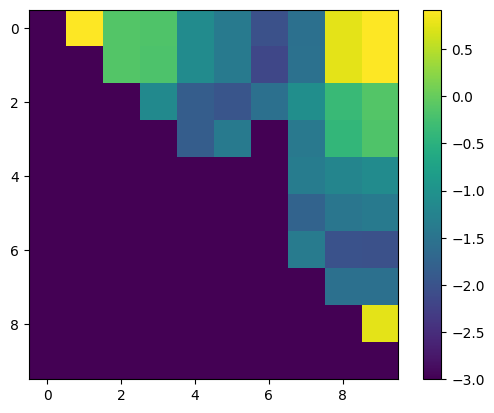

In [4]:
from utils import patch_all_pairs

res = patch_all_pairs(
    model,
    tokenizer,
    "<10 <11 <12 <13 <14 14> 13> 12> 11> 10>",
    "<1 <2 <3 <4 <5 5> 4> 3> 2> 1>",
    layer_list,
)
res = t.triu(res, diagonal=1)
plt.imshow(res.clip(1e-3, 100).log10())
plt.colorbar()
plt.show()

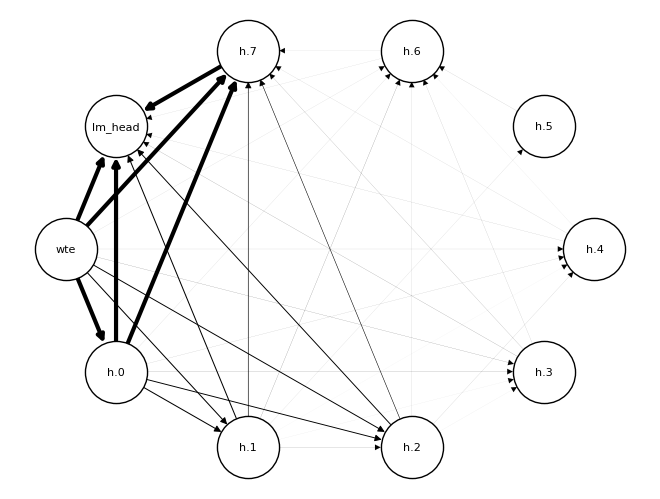

In [5]:
import networkx as nx
from itertools import combinations

G = nx.DiGraph()

short_forms = []
for name in layer_list:
    short_form = ".".join(name.split(".")[1:])
    short_forms.append(short_form)
    G.add_node(short_form)

weights = []
for i_prompt, j in combinations(range(10), 2):
    w = min(res[i_prompt, j].item(), 3.0)
    if w > 0.01:
        G.add_edge(short_forms[i_prompt], short_forms[j])
        weights.append(w)

options = {
    "font_size": 8,
    "node_size": 2000,
    "node_color": "white",
    "edgecolors": "black",
    "linewidths": 1,
}
nx.draw(G, with_labels=True, pos=nx.shell_layout(G), width=weights, **options)

### Replacing layers with $f(x) = x + C$

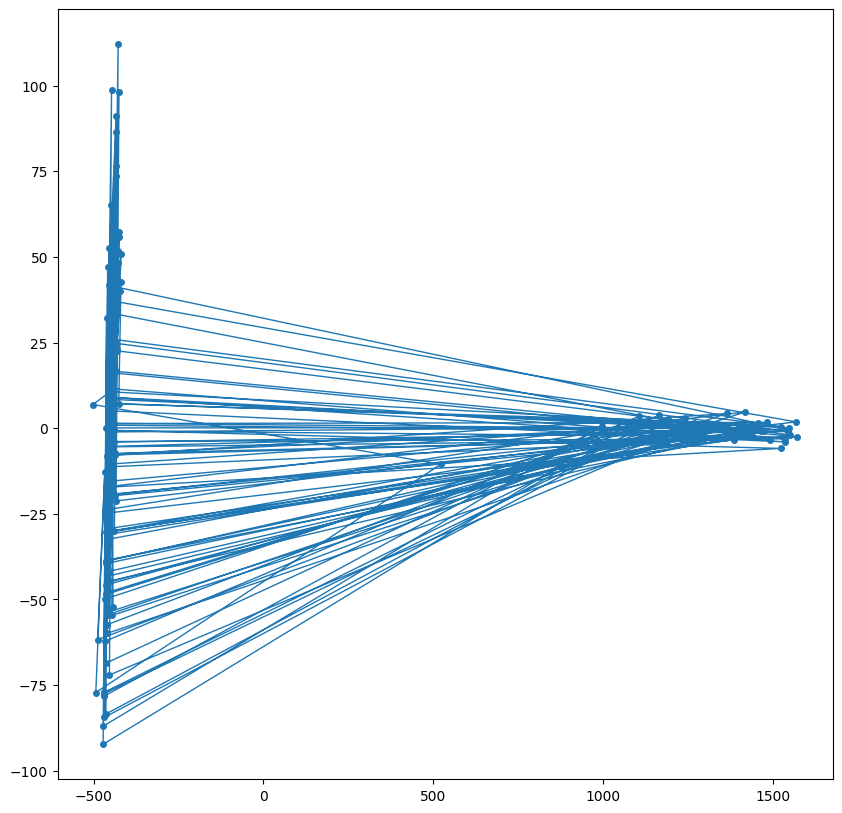

clean: 3.214, corrupted: 3.231
delta: 0.017


In [6]:
from sklearn.decomposition import PCA
from utils import get_activations, get_loss, prompt_from_template

t.set_grad_enabled(False)

layer_deltas = {name: [] for name in layer_list if "h." in name}
for _ in range(100):
    prompt = prompt_from_template("(())" * 40)
    # prompt = "<5 <6 <7 <8 <9 9> 8> 7> 6> 5>"
    inputs_dict, outputs_dict = get_activations(model, tokenizer, prompt)
    for name in layer_deltas:
        delta = (outputs_dict[name][0] - inputs_dict[name][0]).squeeze()
        assert_type(
            delta,
            Float[TT, "seq 256"],
        )
        layer_deltas[name].append(delta)

layer_delta = {name: sum(values) / len(values) for name, values in layer_deltas.items()}


class Adder(nn.Module):
    @typed
    def __init__(self, value: Float[TT, "seq 256"]):
        super().__init__()
        self.value = value

    @typed
    def forward(
        self, x: Float[TT, "... seq 256"], *args, **kwargs
    ) -> tuple[Float[TT, "... seq 256"]]:
        return (x + self.value[..., : x.shape[-2], :],)


s = 0
replace_l = 2
replace_r = 7
for i_prompt in range(replace_l, replace_r):
    s += layer_delta[f"transformer.h.{i_prompt}"]

new_model = AutoModelForCausalLM.from_pretrained("Mlxa/brackets-nested")
new_model.config.use_cache = False
new_model.config.output_attentions = False
new_model.transformer.h = nn.ModuleList(
    new_model.transformer.h[:replace_l]
    + [
        Adder(s),
    ]
    + new_model.transformer.h[replace_r:]
)


pca = PCA(n_components=2, whiten=False)
coords = pca.fit_transform(layer_delta["transformer.h.7"])
plt.figure(figsize=(10, 10))
plt.plot(coords[:, 0], coords[:, 1], "-o", lw=1, ms=4)
plt.show()


prompt = prompt_from_template("(())" * 20)
# prompt = prompt_from_template("(())()(())")
a = get_loss(model, tokenizer, prompt)
b = get_loss(new_model, tokenizer, prompt)
print(f"clean: {a:.3f}, corrupted: {b:.3f}")
print(f"delta: {b - a:.3f}")

## Layerwise analysis

In [251]:
from utils import get_layer_residuals, seed_everything, prompt_from_template

seed_everything(42)
layer_list = ["transformer.wte"] + [f"transformer.h.{i}" for i in range(8)]
n_layers = len(layer_list)
token_set = [f"<{i}" for i in range(100, 120)]
n_tokens = len(token_set)
burn_in = prompt_from_template("()(((())))(())", random=True)
middle_set = [prompt_from_template("(" * n, random=True) for n in (1.5**t.arange(14)).int()]
print(middle_set)
n_templates = len(middle_set)
balances = [s.count("<") - s.count(">") for s in middle_set]
d_model = 256

measurements = t.zeros(n_layers, n_templates, n_tokens, d_model)

secret_directions = t.randn(n_layers, n_tokens, d_model)
secret_baseline = t.randn(n_layers, n_templates, d_model)

for i_middle, middle in enumerate(middle_set):
    for i_token, token in enumerate(token_set):
        prompt = " ".join([burn_in, middle, token])
        assert all(token < 500 for token in tokenizer.encode(prompt))
        activations = get_layer_residuals(model, tokenizer, prompt, layer_list)
        for i_layer, layer in enumerate(layer_list):
            measurements[i_layer, i_middle, i_token] = activations[i_layer][-1]

['<21', '<103', '<122 <211', '<215 <75 <203', '<88 <117 <100 <104 <152', '<131 <150 <53 <2 <88 <236 <158', '<38 <130 <192 <188 <21 <161 <204 <58 <22 <236 <89', '<49 <219 <59 <170 <220 <188 <208 <15 <190 <190 <175 <190 <51 <108 <55 <244 <64', '<249 <131 <229 <51 <135 <21 <73 <167 <18 <132 <89 <60 <14 <242 <250 <9 <90 <53 <130 <84 <92 <111 <188 <199 <172', '<8 <175 <35 <206 <81 <164 <50 <104 <132 <2 <134 <54 <106 <4 <54 <221 <191 <146 <218 <44 <162 <202 <190 <228 <14 <95 <48 <15 <200 <206 <215 <249 <190 <40 <213 <208 <237 <82', '<111 <53 <24 <154 <217 <188 <124 <237 <41 <157 <15 <45 <65 <89 <71 <9 <88 <129 <236 <136 <216 <63 <139 <243 <81 <136 <163 <163 <33 <123 <5 <234 <231 <250 <41 <28 <135 <201 <72 <12 <162 <33 <48 <247 <151 <62 <216 <37 <99 <172 <104 <214 <219 <35 <193 <227 <101', '<175 <206 <131 <1 <5 <218 <247 <142 <103 <27 <137 <207 <15 <90 <42 <124 <205 <179 <63 <96 <231 <241 <52 <96 <132 <222 <229 <151 <231 <237 <143 <171 <29 <36 <13 <160 <71 <187 <243 <86 <28 <66 <170 <45 <62 <

In [252]:
baseline_impact = ein.reduce(
    measurements, "n_layers n_template n_token d_model -> n_layers n_template 1 d_model", "mean"
)
directions = ein.reduce(
    measurements - baseline_impact,
    "n_layers n_template n_token d_model -> n_layers n_token d_model",
    "mean",
)
directions = F.normalize(directions, dim=-1)

In [ ]:
for i_layer in range(1, n_layers):
    print("layer", i_layer)
    for i_token in range(min(n_tokens, 1)):
        for i_prompt in range(n_templates):
            direction = directions[i_layer, i_token]
            assert_type(direction, Float[TT, "d_model"])
            vector = measurements[i_layer, i_prompt, i_token] - baseline_impact[i_layer, i_prompt, 0]
            assert_type(vector, Float[TT, "d_model"])
            cosine_similarity = F.cosine_similarity(direction, vector, dim=0).item()
            print(f"{balances[i_prompt]}, {vector.norm().item():3f}, {cosine_similarity:.4f}")

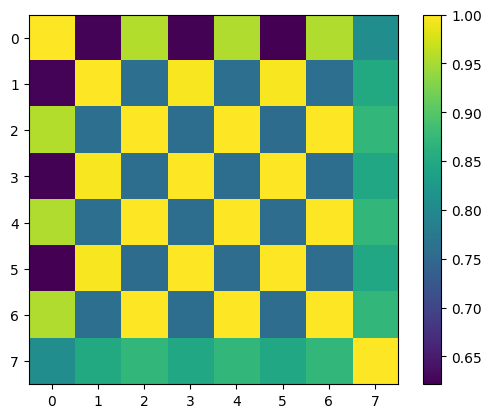

In [273]:
res = t.zeros(n_layers, n_layers)
for i in range(n_layers):
    for j in range(n_layers):
        diff = F.cosine_similarity(
            directions[i].flatten(), directions[j].flatten(), dim=0
        ).item()
        # diff = (baseline_impact[i] - baseline_impact[j]).square().mean().log().item()
        res[i, j] = diff
plt.imshow(res[1:, 1:])
plt.colorbar()
plt.show()

In [332]:
@typed
def get_baseline(prompt: str, layer: int) -> Float[TT, "d_model"]:
    impacts = []
    for token in token_set:
        activations = get_layer_residuals(model, tokenizer, prompt + " " + token, layer_list)
        impacts.append(activations[layer][-1])
    return t.stack(impacts).mean(0)

layer = 3
points = []
points.append(get_baseline("<1 <2 <3", layer=layer))
points.append(get_baseline("<2 <1 <3", layer=layer))
points = t.stack(points)

Hypothesis: baseline is a linear combination of token embeddings weighted by position coefficients.

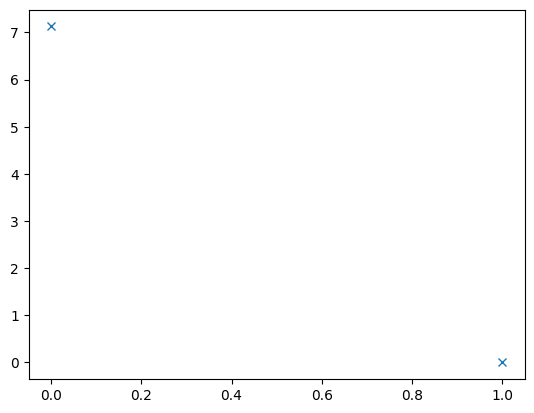

norm 335.2272033691406
unexplained 5.03987979888916


In [333]:
svdvals = t.linalg.svdvals(points - points.mean(dim=0))
plt.plot(svdvals, "x")
plt.show()
print("norm", points.norm(dim=1).mean().item())
print("unexplained", (points - points.mean(dim=0, keepdim=True)).norm(dim=1).mean().item())

# from sklearn.decomposition import PCA

# pca = PCA(n_components=2).fit_transform(points)
# plt.scatter(pca[:, 0], pca[:, 1])
# plt.show()